In [54]:
import unicodedata
import pandas as pd
import numpy as np
import string
import sys
import re
import sklearn
import nltk

from nltk import FreqDist
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import  SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
# from nltk.classify.scikitlearn import  #SKlearnClassifier
from nltk.classify import SklearnClassifier

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import  LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, chi2


import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

np.set_printoptions(linewidth=100)

%autosave 120

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/yamasjose/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/yamasjose/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/yamasjose/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Autosaving every 120 seconds


###  Importing Data

In [2]:
# if on google colab

# import io
# from google.colab import files 
# uploaded = files.upload()

# twitter = pd.read_csv(io.StringIO(uploaded['data/gender-classifier-DFE-791531.csv'].decode('utf-8')))

In [3]:
twitter = pd.read_csv('data/gender-classifier-DFE-791531.csv', encoding='latin-1' )

The dataset contains the following fields:

**unit_id:** a unique id for user

**golden:** whether the user was included in the gold standard for the model; TRUE or FALSE

**unit_state:** state of the observation; one of finalized (for contributor-judged) or golden (for gold standard observations)

**trusted_judgments:** number of trusted judgments (int); always 3 for non-golden, and what may be a unique id for gold standard observations

**last_judgment_at:** date and time of last contributor judgment; blank for gold standard observations

**gender:** one of male, female, or brand (for non-human profiles)

**gender:confidence:** a float representing confidence in the provided gender

**profile_yn:** "no" here seems to mean that the profile was meant to be part of the dataset but was not available when contributors went to judge it

**profile_yn:confidence:** confidence in the existence/non-existence of the profile

**created:** date and time when the profile was created

**description:** the user's profile description

**fav_number:** number of tweets the user has favorited

**gender_gold:** if the profile is golden, what is the gender?

**link_color:** the link color on the profile, as a hex value

**name:** the user's name

**profile_yn_gold:** whether the profile y/n value is golden

**profileimage:** a link to the profile image

**retweet_count:** number of times the user has retweeted (or possibly, been retweeted)

**sidebar_color:** color of the profile sidebar, as a hex value

**text:** text of a random one of the user's tweets

**tweet_coord:** if the user has location turned on, the coordinates as a string with the format "[latitude, longitude]"

**tweet_count:** number of tweets that the user has posted

**tweet_created:** when the random tweet (in the text column) was created

**tweet_id:** the tweet id of the random tweet

**tweet_location:** location of the tweet; seems to not be particularly normalized

**user_timezone:** the timezone of the user

In [4]:
pd.set_option('display.max_columns', None)

twitter.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,description,fav_number,gender_gold,link_color,name,profile_yn_gold,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,i sing my own rhythm.,0,NaN,08C2C2,sheezy0,NaN,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,I'm the author of novels filled with family dr...,68,NaN,0084B4,DavdBurnett,NaN,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,louis whining and squealing and all,7696,NaN,ABB8C2,lwtprettylaugh,NaN,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",202,NaN,0084B4,douggarland,NaN,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,37318,NaN,3B94D9,WilfordGemma,NaN,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN


In [5]:
twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               20050 non-null  int64  
 1   _golden                20050 non-null  bool   
 2   _unit_state            20050 non-null  object 
 3   _trusted_judgments     20050 non-null  int64  
 4   _last_judgment_at      20000 non-null  object 
 5   gender                 19953 non-null  object 
 6   gender:confidence      20024 non-null  float64
 7   profile_yn             20050 non-null  object 
 8   profile_yn:confidence  20050 non-null  float64
 9   created                20050 non-null  object 
 10  description            16306 non-null  object 
 11  fav_number             20050 non-null  int64  
 12  gender_gold            50 non-null     object 
 13  link_color             20050 non-null  object 
 14  name                   20050 non-null  object 
 15  pr

### Exploring data and cleaning it


In [6]:
twitter = twitter.drop(['_golden', '_unit_state', '_trusted_judgments', 'profile_yn', 'gender_gold', 'profile_yn_gold', 'tweet_coord', 'tweet_location', 'user_timezone'], axis = 1) 
# clean_df

In [7]:
twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               20050 non-null  int64  
 1   _last_judgment_at      20000 non-null  object 
 2   gender                 19953 non-null  object 
 3   gender:confidence      20024 non-null  float64
 4   profile_yn:confidence  20050 non-null  float64
 5   created                20050 non-null  object 
 6   description            16306 non-null  object 
 7   fav_number             20050 non-null  int64  
 8   link_color             20050 non-null  object 
 9   name                   20050 non-null  object 
 10  profileimage           20050 non-null  object 
 11  retweet_count          20050 non-null  int64  
 12  sidebar_color          20050 non-null  object 
 13  text                   20050 non-null  object 
 14  tweet_count            20050 non-null  int64  
 15  tw

In [8]:
# fill in missing data
twitter.fillna(value = 'unknown',  
          inplace = True) 

In [9]:
twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               20050 non-null  int64  
 1   _last_judgment_at      20050 non-null  object 
 2   gender                 20050 non-null  object 
 3   gender:confidence      20050 non-null  object 
 4   profile_yn:confidence  20050 non-null  float64
 5   created                20050 non-null  object 
 6   description            20050 non-null  object 
 7   fav_number             20050 non-null  int64  
 8   link_color             20050 non-null  object 
 9   name                   20050 non-null  object 
 10  profileimage           20050 non-null  object 
 11  retweet_count          20050 non-null  int64  
 12  sidebar_color          20050 non-null  object 
 13  text                   20050 non-null  object 
 14  tweet_count            20050 non-null  int64  
 15  tw

In [10]:
twitter.gender.value_counts()

female     6700
male       6194
brand      5942
unknown    1214
Name: gender, dtype: int64

## NLP Pipeline 

Below is a to do list when converting text into vector form: 

**Clean text and Create a Bag of Words (BoW)**
>1. Lowercase the text
2. Tokenize 
3. Strip out punctuation or undesirable text
4. Remove Stopwords 
5. Stemming or Lemmatizing
6. Compute N-Grams
7. Use this to create BoW

**Vectorize BoW**
>8. Term Frequencies
9. Document Frequencies
10. TF-IDF
11. Normalize vectors



In [11]:
# twitter

In [12]:
type(twitter.gender), type(twitter.text)

(pandas.core.series.Series, pandas.core.series.Series)

In [13]:
classes = twitter['gender']
print(classes.value_counts())

female     6700
male       6194
brand      5942
unknown    1214
Name: gender, dtype: int64


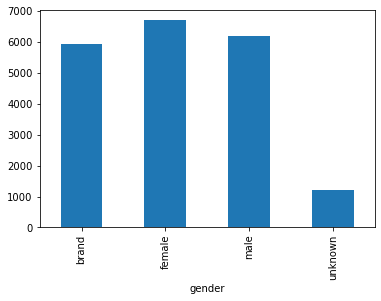

In [14]:
# tweets per gender per data
twitter.groupby('gender').text.count().plot.bar(ylim=0)
plt.show()

In [15]:
# plot of "words" per gender?


###  Consider dropping unknown to reduce uncertainty for more accuracy?


In [16]:
encoder = LabelEncoder()
Y = encoder.fit_transform(classes)

# print(classes[:15])
print(Y[:15])

[2 2 2 2 1 1 0 2 1 1 0 0 1 0 1]


In [17]:
twitter.text[:15]

0     Robbie E Responds To Critics After Win Against...
1     ÛÏIt felt like they were my friends and I was...
2     i absolutely adore when louis starts the songs...
3     Hi @JordanSpieth - Looking at the url - do you...
4     Watching Neighbours on Sky+ catching up with t...
5     Ive seen people on the train with lamps, chair...
6     @BpackEngineer Thank you for your patience whi...
7     Gala Bingo clubs bought for å£241m: The UK's l...
8     @_Aphmau_ the pic defines all mcd fangirls/fan...
9     @Evielady just how lovely is the tree this yea...
10    how are you taking care of yourself? https://t...
11    MTG Deals 1x Rank-Up-Magic - The Seventh One -...
12    Just put my ass on the line for you and this i...
13    https://t.co/z4sbWUugd8 What the Nation Will B...
14    will i even need sound effects for the diviner...
Name: text, dtype: object

In [18]:
tweets = twitter.text
tweets

0        Robbie E Responds To Critics After Win Against...
1        ÛÏIt felt like they were my friends and I was...
2        i absolutely adore when louis starts the songs...
3        Hi @JordanSpieth - Looking at the url - do you...
4        Watching Neighbours on Sky+ catching up with t...
                               ...                        
20045    @lookupondeath ...Fine, and I'll drink tea too...
20046    Greg Hardy you a good player and all but don't...
20047    You can miss people and still never want to se...
20048    @bitemyapp i had noticed your tendency to pee ...
20049    I think for my APUSH creative project I'm goin...
Name: text, Length: 20050, dtype: object

###   Cleaning  text 

In [19]:
pt = string.punctuation
pt

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [20]:
# removing @s and links
for i,doc in enumerate(tweets):
    tweets[i] = re.sub(r"(?:\@|https?\://)\S+", "", doc)
    tweets[i] = " ".join(tweets[i].split())
# tweets[:15]

/home/yamasjose/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/yamasjose/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [21]:
# We will analyze not using emojis and re iterate through the same data with emojis

# let's start by removing emojis and other special characters
for i,doc in enumerate(tweets):
    tweets[i] = unicodedata.normalize('NFKD', doc).encode('ASCII', 'ignore').decode('utf8')

# tweets, len(tweets)

/home/yamasjose/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [22]:
# clean punctuation
tweets = tweets.str.replace(r'[^\w\d\s]', ' ')
# clean_tweets[:20]

In [23]:
# clean numbers
tweets = tweets.str.replace(r'\d+(\.\d+)?', ' ')
# tweets[:20]

In [24]:
# clean whitespaces
tweets = tweets.str.replace(r'\s+', ' ')
# tweets[:20]

In [25]:
# clean extra whitespaces
tweets = tweets.str.replace(r'^\s+|\s+?$', '')
# tweets[:20]

In [26]:
# lower
tweets = tweets.str.lower()
tweets[:20]

0     robbie e responds to critics after win against...
1     uiit felt like they were my friends and i was ...
2     i absolutely adore when louis starts the songs...
3     hi looking at the url do you use don t typical...
4     watching neighbours on sky catching up with th...
5     ive seen people on the train with lamps chairs...
6     thank you for your patience while we take care...
7     gala bingo clubs bought for a m the uk s large...
8     the pic defines all mcd fangirls fanboys and m...
9     just how lovely is the tree this year never se...
10     how are you taking care of yourself fitfluential
11    mtg deals x rank up magic the seventh one prio...
12    just put my ass on the line for you and this i...
13    what the nation will be talking about after we...
14    will i even need sound effects for the diviner...
15              it s a glow of satisfaction re the glow
16    lmao _ua_ua dude i m hella scared for next epi...
17    ditto i m still learning the favourites an

### reconsider what stopwords are meaningful to not remove, 

In [27]:
# remove stop words
stop_words = set(stopwords.words('english'))

tweets = tweets.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))
tweets[:15]

0     robbie e responds critics win eddie edwards wo...
1     uiit felt like friends living story themu reti...
2     absolutely adore louis starts songs hits hard ...
3        hi looking url use typically see advanced user
4     watching neighbours sky catching neighbs xxx _...
5            ive seen people train lamps chairs tvs etc
6                        thank patience take care issue
7     gala bingo clubs bought uk largest high street...
8      pic defines mcd fangirls fanboys mcd shippers xd
9     lovely tree year never seen gorgeous autumn co...
10                             taking care fitfluential
11    mtg deals x rank magic seventh one prio en sec...
12                                   put ass line repay
13        nation talking wednesday gop debates business
14             even need sound effects diviners tonight
Name: text, dtype: object

# 

### Creating a Bag of Words (BoW)

In [ ]:
# Stemming and lemmatizing
porter = PorterStemmer()
snowball = SnowballStemmer('english')
wordnet = WordNetLemmatizer()

porter_tweets = tweets.apply(lambda x: ' '.join(porter.stem(word) for word in x.split()))
snowball_tweets = tweets.apply(lambda x: ' '.join(snowball.stem(word) for word in x.split()))
wordnet_tweets = tweets.apply(lambda x: ' '.join(wordnet.lemmatize(word) for word in x.split()))

# porter_tweets

In [ ]:
# create function to call on snowball and wordnet
bow_fd = []
for x in porter_tweets:
    words = word_tokenize(x)
    for w in words:
        bow_fd.append(w)
        
bow_fd = nltk.FreqDist(bow_fd)

In [ ]:
print('{}'.format(len(bow_fd)))
print('{}'.format(bow_fd.most_common(20)))

In [ ]:
# bow_fd

In [ ]:
word_lim_1000 = list(bow_fd.keys())[:1000]
word_lim_1000

In [ ]:
word_lim_5000 = list(bow_fd.keys())[:5000]
word_lim_5000

In [ ]:
def features_(x, word_lim):
    words = word_tokenize(x)
    features = {}
    for y in word_lim:
        features[x] = (x in words)
        
    return features

### Porter

In [ ]:
tweet_features = list(zip(porter_tweets, Y))

seed = 1
np.random.seed = seed
np.random.shuffle(tweet_features)

features = [(features_(x, word_lim_5000), marker) for (text, marker) in tweet_features]

In [ ]:
training, testing = model_selection.train_test_split(features, test_size=0.2)

len(training), len(testing)

In [ ]:
names = ['K Nearest Neighbors', 'Decision Tree', 'Random Forest', 'Naive Bayes']

classifiers = [KNeighborsClassifier(), 
              DecisionTreeClassifier(), 
              RandomForestClassifier(), 
              MultinomialNB() 
              ]

models = list(zip(names, classifiers))

In [ ]:
for name, model in models:
    nltk_model = SklearnClassifier(model)
    nltk_model.train(training)
    acc = nltk.classify.accuracy(nltk_model, testing)
    print('{}: {}'.format(name, acc))

## Snow

In [ ]:
# create function to call on snowball and wordnet
bow_fd_snow = []
for x in snowball_tweets:
    words = word_tokenize(x)
    for w in words:
        bow_fd_snow.append(w)
        
bow_fd_snow = nltk.FreqDist(bow_fd)

print('{}'.format(len(bow_fd_snow)))
print('{}'.format(bow_fd_snow.most_common(20)))

In [ ]:
tweet_features_snow = list(zip(snowball_tweets, Y))

seed = 1
np.random.seed = seed
np.random.shuffle(tweet_features_snow)

features_snow = [(features_(x, word_lim_5000), marker) for (text, marker) in tweet_features_snow]

In [ ]:
training_snow, testing_snow = model_selection.train_test_split(features_snow, test_size=0.2)

len(training_snow), len(testing_snow)

In [ ]:
for name, model in models:
    nltk_model_snow = SklearnClassifier(model)
    nltk_model_snow.train(training_snow)
    acc_snow = nltk.classify.accuracy(nltk_model_snow, testing_snow)
    print('{}: {}'.format(name, acc_snow))

### Wordnet

In [ ]:
# create function to call on snowball and wordnet
bow_fd_wordnet = []
for x in wordnet_tweets:
    words = word_tokenize(x)
    for w in words:
        bow_fd_wordnet.append(w)
        
bow_fd_wordnet = nltk.FreqDist(bow_fd)

print(len(bow_fd_wordnet))
print(bow_fd_wordnet.most_common(20))

In [ ]:
tweet_features_wordnet = list(zip(wordnet_tweets, Y))

seed = 1
np.random.seed = seed
np.random.shuffle(tweet_features_wordnet)

features_wordnet = [(features_(x, word_lim_5000), marker) for (text, marker) in tweet_features_wordnet]

In [ ]:
training_wordnet, testing_wordnet = model_selection.train_test_split(features_wordnet, test_size=0.2)

len(training_wordnet), len(testing_wordnet)

In [ ]:
for name, model in models:
    nltk_model_wordnet = SklearnClassifier(model)
    nltk_model_wordnet.train(training_wordnet)
    acc_wordnet = nltk.classify.accuracy(nltk_model_wordnet, testing_wordnet)
    print('{}: ACC: {}'.format(name, acc_wordnet))

In [ ]:
# Stemming and lemmatizing
porter = PorterStemmer()
snowball = SnowballStemmer('english')
wordnet = WordNetLemmatizer()

# changes tweets
porter_tweets = tweets.apply(lambda x: ' '.join(porter.stem(word) for word in x.split()))
snowball_tweets = tweets.apply(lambda x: ' '.join(snowball.stem(word) for word in x.split()))
wordnet_tweets = tweets.apply(lambda x: ' '.join(wordnet.lemmatize(word) for word in x.split()))

# porter_tweets

## Seperation of Genders ATMP 2

In [28]:
twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               20050 non-null  int64  
 1   _last_judgment_at      20050 non-null  object 
 2   gender                 20050 non-null  object 
 3   gender:confidence      20050 non-null  object 
 4   profile_yn:confidence  20050 non-null  float64
 5   created                20050 non-null  object 
 6   description            20050 non-null  object 
 7   fav_number             20050 non-null  int64  
 8   link_color             20050 non-null  object 
 9   name                   20050 non-null  object 
 10  profileimage           20050 non-null  object 
 11  retweet_count          20050 non-null  int64  
 12  sidebar_color          20050 non-null  object 
 13  text                   20050 non-null  object 
 14  tweet_count            20050 non-null  int64  
 15  tw

In [29]:
twitter.gender.value_counts()

female     6700
male       6194
brand      5942
unknown    1214
Name: gender, dtype: int64

In [30]:
# male = [twitter['gender'] ==  'Male']
# male

In [31]:
# classes = twitter['gender']
# print(classes.value_counts())

In [32]:
# tweets

In [33]:
X = tweets
y = twitter.gender

# X, y

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# X_train, X_test, y_train, y_test

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

pipel = Pipeline([('vect', CountVectorizer()), 
                  ('tfidf', TfidfTransformer()), 
                  ('clf', MultinomialNB())])

pipel.fit(X_train, y_train)

In [ ]:
y_pred = pipel.predict(X_test)
# y_pred

In [ ]:
print('accuracy: %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

In [ ]:
print('accuracy: %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=twitter.gender.unique()))

### restructure tweets without unknown gender and run model again - new_df1

In [ ]:
twitter.info()

In [ ]:
twitter.head()

In [ ]:
# twitter_wo_uk = twitter[twitter['gender'] != 'unknown']
# twitter_wo_uk

In [ ]:
twitter_backup = twitter.copy()

In [ ]:
twitter.gender.value_counts()

In [ ]:
# twitter_wo_uk = twitter.copy()

In [ ]:
# twitter_wo_uk.head()

In [ ]:
# twitter_wo_uk = twitter.drop(twitter[twitter['gender'] != 'unknown'].index, inplace = True) 
# twitter_wo_uk

In [ ]:
new_df = twitter[twitter['gender'] != 'unknown']
# new_df.info()

In [ ]:
new_df1 = new_df.reset_index()
# new_df1.info()

In [ ]:
len(new_df1.gender), len(new_df1.text)

In [ ]:
# new_df1.text

In [ ]:
len(clean_data(new_df1.text))

In [ ]:
tweets_newdf = clean_data(new_df1.text)

In [ ]:
X = tweets_newdf
y = new_df1.gender

# X, y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# X_train, X_test, y_train, y_test

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

pipel = Pipeline([('vect', CountVectorizer()), 
                  ('tfidf', TfidfTransformer()), 
                  ('clf', MultinomialNB())])

pipel.fit(X_train, y_train)

In [ ]:
y_pred = pipel.predict(X_test)
# y_pred

In [ ]:
print('accuracy: %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

In [ ]:
print('accuracy: %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=new_df1.gender.unique()))

## Again now without unknown and brand 

In [ ]:
twitter.info()

In [ ]:
# twitter.head()

In [ ]:
# twitter_wo_uk = twitter[twitter['gender'] != 'unknown']
# twitter_wo_uk

In [ ]:
# twitter_backup = twitter.copy()

In [ ]:
twitter.gender.value_counts()

In [ ]:
# twitter_wo_uk = twitter.copy()

In [ ]:
# twitter_wo_uk.head()

In [ ]:
# twitter_wo_uk = twitter.drop(twitter[twitter['gender'] != 'unknown'].index, inplace = True) 
# twitter_wo_uk

In [ ]:
df_b_uk = twitter[twitter['gender'] != 'unknown']
df_b_uk.info()

In [ ]:
df_b_uk = df_b_uk.reset_index()
df_b_uk.info()

In [ ]:
df_b_uk = df_b_uk[df_b_uk['gender'] != 'brand']
df_b_uk.info()

In [ ]:
df_b_uk = df_b_uk.reset_index()
df_b_uk.info()

In [ ]:
len(df_b_uk.gender), len(df_b_uk.text)

In [ ]:
df_b_uk.text

In [ ]:
len(clean_data(df_b_uk.text))

In [ ]:
tweets_df_b_uk = clean_data(df_b_uk.text)
tweets_df_b_uk

In [ ]:
X = tweets_newdf
y = new_df1.gender

# tweets_newdf
# new_df1
# df_b_uk
# X, y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# X_train, X_test, y_train, y_test

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, chi2

pipel = Pipeline([('vect', CountVectorizer()), 
                  ('tfidf', TfidfTransformer()), 
                  ('clf', MultinomialNB())])

pipel.fit(X_train, y_train)

In [ ]:
y_pred = pipel.predict(X_test)
y_pred

In [ ]:
print('accuracy: %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

In [ ]:
print('accuracy: %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=df_b_uk.gender.unique()))

## New method - Approach

In [35]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, chi2

In [36]:
pipel2 = Pipeline([('vect', CountVectorizer()), 
                  ('tfidf', TfidfTransformer()), 
                  ('clf', SGDClassifier())])

pipel2.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier())])

In [37]:
y_pred = pipel2.predict(X_test)
# y_pred

In [38]:
print('accuracy: %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy: 0.49975062344139654
              precision    recall  f1-score   support

       brand       0.60      0.58      0.59      1213
      female       0.48      0.62      0.54      1307
        male       0.43      0.39      0.41      1243
     unknown       0.27      0.04      0.06       247

    accuracy                           0.50      4010
   macro avg       0.45      0.41      0.40      4010
weighted avg       0.49      0.50      0.49      4010



In [ ]:
# pipel.get_params().keys()

In [ ]:
pipel2.get_params().keys()

## Another New approach

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, chi2

In [ ]:
classes = twitter['gender']
print(classes.value_counts())

In [ ]:
X = tweets_newdf
y = new_df1.gender

# tweets_newdf
# new_df1
# df_b_uk
# X, y

In [ ]:
# X = tweets_df_b_uk
# y = df_b_uk.gender
# #
# print(X, y)

In [ ]:
encoder = LabelEncoder()
Y = encoder.fit_transform(y)
Y = Y.astype('int')
# print(classes[:15])
print(Y[:25])
type(Y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
# X_train, X_test, y_train, y_test

In [ ]:
# vect = CountVectorizer()
# X = vect.fit_transform(tweets_df_b_uk)

In [ ]:
pipel3 = Pipeline([('vect', CountVectorizer()), 
                  ('tfidf', TfidfTransformer()), 
                  ('clf', RandomForestRegressor())])

pipel3.fit(X_train, y_train)
ytest = np.array(y_test)

In [ ]:
y_pred = pipel3.predict(X_test)
y_pred

## pipel4  


## pipel4  

In [39]:
from sklearn.feature_selection import SelectKBest, chi2

In [43]:
def  clean_data(tweets1):

    # removing @s and links
    for i,doc in enumerate(tweets1):
        tweets[i] = re.sub(r"(?:\@|https?\://)\S+", "", doc)
        tweets[i] = " ".join(tweets[i].split())
    # tweets[:15]

    ### We will analyze not using emojis and re iterate through the same data with emojis

    # let's start by removing emojis and other special characters
    for i,doc in enumerate(tweets1):
        tweets1[i] = unicodedata.normalize('NFKD', doc).encode('ASCII', 'ignore').decode('utf8')

    # tweets, len(tweets)

    # clean punctuation
    tweets1 = tweets1.str.replace(r'[^\w\d\s]', ' ')
    # clean_tweets[:20]

    # clean numbers
    tweets1 = tweets1.str.replace(r'\d+(\.\d+)?', ' ')
    # tweets[:20]

    # clean whitespaces
    tweets1 = tweets1.str.replace(r'\s+', ' ')
    # tweets[:20]

    # clean extra whitespaces
    tweets1 = tweets1.str.replace(r'^\s+|\s+?$', '')
    # tweets[:20]

    # lower
    tweets1 = tweets1.str.lower()
    # tweets[:20]
    
    return tweets1
    


In [131]:
new_df = twitter[twitter['gender'] != 'unknown']
# new_df.info()

new_df1 = new_df.reset_index()
# new_df1.info()


In [132]:
len(new_df1.gender), len(new_df1.text)

# new_df1.text

len(clean_data(new_df1.text))

/home/yamasjose/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


18836

In [133]:
tweets_newdf = clean_data(new_df1.text)

/home/yamasjose/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [134]:
X = tweets_newdf
y = new_df1.gender

# tweets_newdf
# new_df1
# df_b_uk
# X, y

# X = tweets_df_b_uk
# y = df_b_uk.gender
# #
# print(X, y)

In [135]:
encoder = LabelEncoder()
Y = encoder.fit_transform(y)
Y = Y.astype('int')
# print(classes[:15])
print(Y[:25])
type(Y)

[2 2 2 2 1 1 0 2 1 1 0 0 1 0 1 1 1 2 2 1 1 1 2 2 1]


numpy.ndarray

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
# X_train, X_test, y_train, y_test

In [145]:
pipel4 = Pipeline([('vect', CountVectorizer()), 
                  ('chi',  SelectKBest(chi2, k=1200)), 
                  ('clf', RandomForestRegressor(n_estimators=100))])

pipel4.fit(X_train, y_train)


Pipeline(steps=[('vect', CountVectorizer()),
                ('chi',
                 SelectKBest(k=1200,
                             score_func=<function chi2 at 0x7f47dbf21170>)),
                ('clf', RandomForestRegressor())])

In [146]:
ytest = np.array(y_test)
ytest

array([1, 0, 2, ..., 1, 0, 2])

In [153]:
y_pred = pipel4.predict(X_test)

y_pred = y_pred.astype('int')
# y_pred[:75]

In [154]:
# len(ytest), len(y_pred), type(ytest), type(y_pred)

In [155]:
pipel4.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vect', 'chi', 'clf', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'chi__k', 'chi__score_func', 'clf__bootstrap', 'clf__ccp_alpha', 'clf__criterion', 'clf__max_depth', 'clf__max_features', 'clf__max_leaf_nodes', 'clf__max_samples', 'clf__min_impurity_decrease', 'clf__min_impurity_split', 'clf__min_samples_leaf', 'clf__min_samples_split', 'clf__min_weight_fraction_leaf', 'clf__n_estimators', 'clf__n_jobs', 'clf__oob_score', 'clf__random_state', 'clf__verbose', 'clf__warm_start'])

In [156]:
print('Accuracy = ', accuracy_score(y_test, y_pred))

Accuracy =  0.4840764331210191


In [157]:
print('Accuracy = ', accuracy_score(y_test, y_pred))
print(classification_report(ytest, y_pred))

Accuracy =  0.4840764331210191
              precision    recall  f1-score   support

           0       0.56      0.62      0.59      1203
           1       0.44      0.77      0.56      1397
           2       1.00      0.00      0.00      1168

    accuracy                           0.48      3768
   macro avg       0.67      0.46      0.38      3768
weighted avg       0.65      0.48      0.40      3768



In [158]:
print(confusion_matrix(ytest, y_pred))

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
conf_matrx = confusion_matrix(ytest, y_pred)

sn.heatmap(conf_matrx)

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 

In [ ]:
pipel3.score(X_test, y_test)

In [ ]:
# print(classification_report(ytest, y_pred))

In [ ]:
# print('accuracy: %s' % accuracy_score(y_pred, y_test))
# print(classification_report(y_test, y_pred))

In [ ]:
# pipel.get_params().keys()

In [ ]:
# twitter_wo_uk = twitter.drop[twitter['gender'] != 'unknown']
# twitter_wo_uk.info()

In [ ]:
# twitter.info()

In [ ]:
def  clean_data(tweets1):

    # removing @s and links
    for i,doc in enumerate(tweets1):
        tweets[i] = re.sub(r"(?:\@|https?\://)\S+", "", doc)
        tweets[i] = " ".join(tweets[i].split())
    # tweets[:15]

    ### We will analyze not using emojis and re iterate through the same data with emojis

    # let's start by removing emojis and other special characters
    for i,doc in enumerate(tweets1):
        tweets1[i] = unicodedata.normalize('NFKD', doc).encode('ASCII', 'ignore').decode('utf8')

    # tweets, len(tweets)

    # clean punctuation
    tweets1 = tweets1.str.replace(r'[^\w\d\s]', ' ')
    # clean_tweets[:20]

    # clean numbers
    tweets1 = tweets1.str.replace(r'\d+(\.\d+)?', ' ')
    # tweets[:20]

    # clean whitespaces
    tweets1 = tweets1.str.replace(r'\s+', ' ')
    # tweets[:20]

    # clean extra whitespaces
    tweets1 = tweets1.str.replace(r'^\s+|\s+?$', '')
    # tweets[:20]

    # lower
    tweets1 = tweets1.str.lower()
    # tweets[:20]
    
    return tweets1
    


In [ ]:
# twitter_wo_uk.text

In [ ]:
# len(twitter_wo_uk.text)

In [ ]:
# type(twitter_wo_uk.text)

In [ ]:
# tweets_wo_uk = clean_data(twitter_wo_uk.text)
# tweets_wo_uk, len(tweets_wo_uk)

In [ ]:
# len(twitter_wo_uk), len(tweets_wo_uk)

In [ ]:
# X = tweets_wo_uk
# y = twitter_wo_uk.gender

# # X, y

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# # X_train, X_test, y_train, y_test

# from sklearn.pipeline import Pipeline
# from sklearn.metrics import classification_report

# pipel = Pipeline([('vect', CountVectorizer()), 
#                   ('tfidf', TfidfTransformer()), 
#                   ('clf', MultinomialNB())])

# pipel.fit(X_train, y_train)

# y_pred = pipel.predict(X_test)
# # y_pred

# print('accuracy: %s' % accuracy_score(y_pred, y_test))
# print(classification_report(y_test, y_pred))

# print('accuracy: %s' % accuracy_score(y_pred, y_test))
# print(classification_report(y_test, y_pred, target_names=twitter.gender.unique()))